# Домашняя-зачетная работа
Студент: Савин Александр Юрьевич

Команда: АТ-07

## Постановка задачи:
Необходимо классифицировать гримасы на лице человека.<br>
Был использован датасет: https://universe.roboflow.com/cnnmodel/grimace_mode-fztjg

## Подключение библиотек

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch timm scikit-learn pandas torchinfo gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.9 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torchinfo import summary
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

# Доп импорты
import zipfile
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from IPython.display import clear_output

# Отображение графиков
%matplotlib inline

## Подготовка датасета


In [ ]:
!gdown 1RZP9ZBtBzxTx8QCp_YSo0mvIw7wzs6it

Downloading...
From (original): https://drive.google.com/uc?id=1RZP9ZBtBzxTx8QCp_YSo0mvIw7wzs6it
From (redirected): https://drive.google.com/uc?id=1RZP9ZBtBzxTx8QCp_YSo0mvIw7wzs6it&confirm=t&uuid=3d8782dd-1579-4cd8-87e0-8e48dfcd378c
To: /content/Grimace_mode.v4i.folder.zip
100% 333M/333M [00:11<00:00, 29.3MB/s]


In [ ]:
# Распаковка датасета
dataset_path = '/content/dataset/'
with zipfile.ZipFile('/content/Grimace_mode.v4i.folder.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

In [ ]:
# Словарь 'имя класса --> класс'
name_to_class = {
    'DOO': 0,
    'Nothing': 1,
    'closes eyes': 2,
    'open mouth': 3,
    'smile': 4,
    'tongue out': 5
}

In [ ]:
# Подготовка датасета
all_items = os.listdir(dataset_path)
folders = [item for item in all_items if os.path.isdir(os.path.join(dataset_path, item))]

for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    image = []
    classes = []
    for file in os.listdir(folder_path):
        if file in name_to_class:
            class_label = name_to_class[file]
            file_path = os.path.join(folder_path, file)
            for c in os.listdir(file_path):
                source_path = os.path.join(file_path, c)
                destination_path = os.path.join(folder_path, c)
                shutil.move(source_path, destination_path)
                image.append(c)
                classes.append(class_label)
            os.rmdir(file_path)
    data = {'filename': image, 'class': classes}
    df = pd.DataFrame(data)
    csv_path = os.path.join(folder_path, 'classes.csv')
    df.to_csv(csv_path, index=False)

In [ ]:
# Класс датасета
class WorkDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

## Архитектура модели

In [ ]:
# Класс модели
class WorkModel(nn.Module):
    def __init__(self):
        super(WorkModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn4(self.conv4(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train/val циклы

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

## Инициализация остальных параметров и запуск обучения

In [ ]:
# сохранение весов
def save_checkpoint(save_path, state, epoch, suffix):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, f"checkpoint_{epoch}_{suffix}.pth")
    torch.save(state, filename)

# получаем лернинг рейт из оптимайзера
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
config = {
    'seed': 42,
    'learning_rate': 1e-4,
    'input_size': 128,
    'input_channels': 3,
    'num_classes': 6,
    'total_epochs': 30,
    'save_epoch': 5,
    'save_path': './checkpoints',
    'batch_size': 32
}

In [ ]:
torch.manual_seed(config['seed'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# аугментация
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Reduced color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# создаем датасеты и лоадеры
train_dataset = WorkDataset(csv_file='dataset/train/classes.csv', root_dir='dataset/train', transform=transform)
val_dataset = WorkDataset(csv_file='dataset/valid/classes.csv', root_dir='dataset/valid', transform=transform)
test_dataset = WorkDataset(csv_file='dataset/test/classes.csv', root_dir='dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [ ]:
# создаем объекты модели, лоса, оптимайзера, и шедулера
model = WorkModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


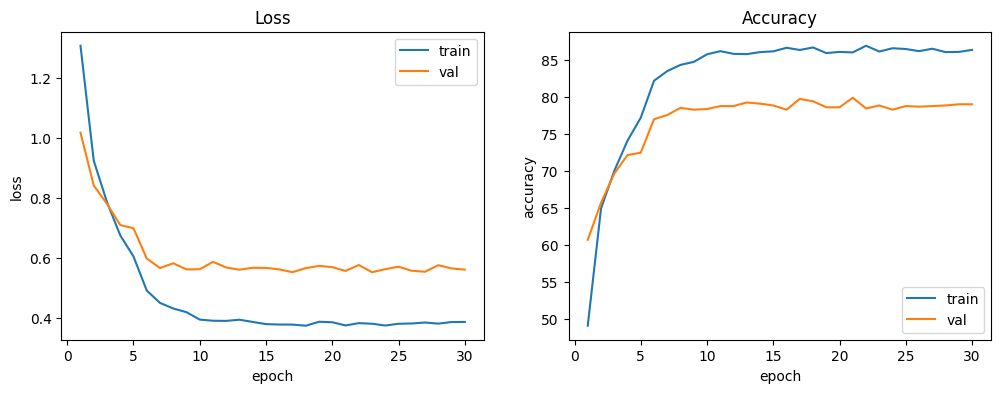

[30/29]		LR: 1e-09		Train loss: 0.388		Train acc: 86.3		Val loss: 0.562		Val acc: 79.0
Stop train


In [ ]:
# начинаем тренить
print('Start train')
log = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, config['total_epochs'] + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    # сохраняем веса
    if epoch % config['save_epoch'] == 0:
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'loss': val_loss,
            'acc': val_acc,
            'optimizer': optimizer.state_dict(),
            'criterion': criterion.state_dict(),
            'input_shape': (config['input_size'], config['input_size'], config['input_channels']),
            'num_classes': config['num_classes']
        }
        save_checkpoint(config['save_path'], state, epoch, '')

    log['epoch'].append(epoch)
    log['train_loss'].append(train_loss)
    log['val_loss'].append(val_loss)
    log['train_acc'].append(train_acc)
    log['val_acc'].append(val_acc)

    clear_output(wait=True)
    # рисуем графики
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(log['epoch'], log['train_loss'], label='train')
    plt.plot(log['epoch'], log['val_loss'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(log['epoch'], log['train_acc'], label='train')
    plt.plot(log['epoch'], log['val_acc'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy')
    plt.show()

    line = '[{}/{}]\t\tLR: {:.2}\t\tTrain loss: {:.3}\t\tTrain acc: {:.3}\t\tVal loss: {:.3}\t\tVal acc: {:.3}'.format(
        epoch,
        config['total_epochs']-1,
        get_lr(optimizer),
        train_loss,
        train_acc,
        val_loss,
        val_acc
    )
    print(line)
    scheduler.step()

print('Stop train')

## Визуализация результатов

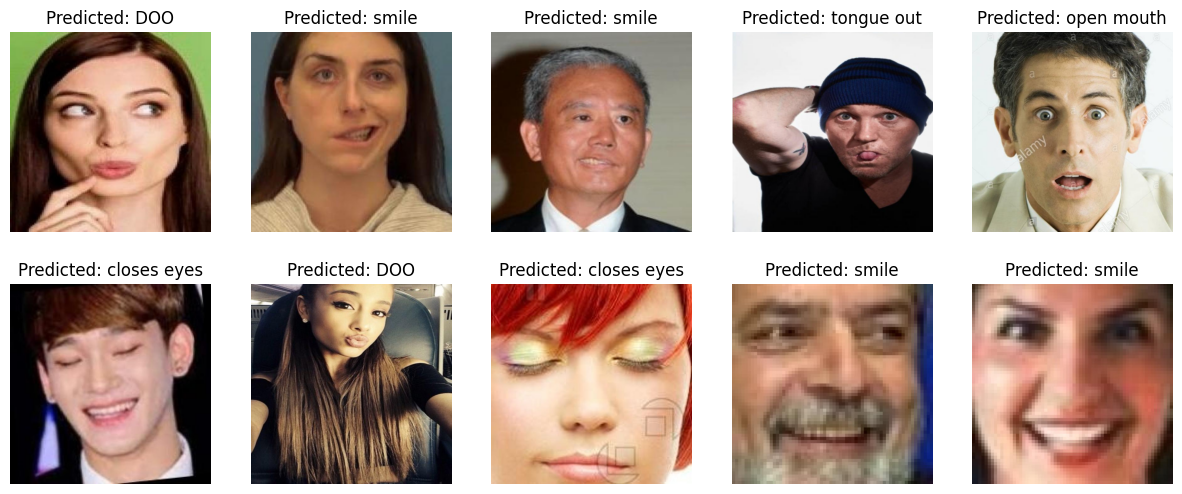

In [ ]:
class_to_name = {v: k for k, v in name_to_class.items()}

checkpoint_path = 'checkpoints/checkpoint_30_.pth'
checkpoint = torch.load(checkpoint_path)
model = WorkModel()
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.to(device)

# предобработка изображений
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# функция для загрузки и предобработки изображения
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0)
    return image

# получение всех путей к изображениям в папке
image_folder = 'dataset/test'
all_image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('png', 'jpg', 'jpeg'))]

# случайный выбор 10 изображений
random_image_paths = random.sample(all_image_paths, 10)
images = [load_image(img_path).to(device) for img_path in random_image_paths]

# преобразование списка изображений в тензор
images_tensor = torch.cat(images)

# выполнение предсказаний
with torch.no_grad():
    outputs = model(images_tensor)
_, preds = torch.max(outputs, 1)

# рисуем изображения и классы
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, img_path in enumerate(random_image_paths):
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].set_title(f'Predicted: {class_to_name[preds[i].item()]}')
    axs[i].axis('off')
plt.show()